# Demand Forecaster with Tensorflow

## 1) Business problem

URL Project: [Sales Prediction for Big Mart Outlets](https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets?select=test.csv)

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

**Data Dictionary**

We have a train (8523) and test (5681) data set, the train data set has both input and output variable(s). You need to predict the sales for the test data set.

#### Train file:
CSV containing the item outlet information with a sales value

**Variable Description**
* *Item_Identifier*: Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*: Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*: Maximum Retail Price (list price) of the product
* *Outlet_Identifier*: Unique store ID
* *Outlet_Establishment_Year*: The year in which the store was established
* *Outlet_Size*: The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: Whether the outlet is just a grocery store or some sort of supermarket
* *Item_Outlet_Sales*: sales of the product in t particular store. This is the outcome variable to be predicted.

### Test file:
CSV containing item outlet combinations for which sales need to be forecasted

**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*:  Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*:  Maximum Retail Price (list price) of the product
* *Outlet_Identifier*:  Unique store ID
* *Outlet_Establishment_Year*:  The year in which store store was established
* *Outlet_Size*:  The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: whether the outlet is just a grocery store or some sort of supermarket

### Submission file format
**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Outlet_Identifier*:  Unique store ID
* *Item_Outlet_Sales*:  Sales of the product in t particular store. This is the outcome variable to be predicted.

**Evaluation Metric**

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in the same sample submission.

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

### 1.1) Imports and Load Data

In [198]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context("paper")

In [199]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [200]:
import tensorflow as tf

tf.__version__

'2.15.0'

### 1.2) Utilities Functions

In [201]:
def currencyFormatting(value):
    if value / 1000000 > 1:
        return f'$ {str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'$ {str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'$ {str(round(value/10000, 2))}k'
    else: 
        return f'$ {str(round(value, 2))}'

In [202]:
def resumeNumber(value):
    if value / 1000000 > 1:
        return f'{str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'{str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'{str(round(value/10000, 2))}k'
    else: 
        return f'{str(round(value, 2))}'

### 1.3) Load data

In [203]:
df_train_raw = pd.read_parquet('../data/x_train_transformed.parquet', engine='pyarrow')
df_test_raw = pd.read_parquet('../data/x_test_transformed.parquet', engine='pyarrow')

### 1.4) EDA

In [204]:
display(df_train_raw.shape)
display(df_train_raw.head(2))
display(df_test_raw.shape)
display(df_test_raw.head(2))

(7670, 35)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Identifier_ordinal,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Location_Type_Tier_3,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Outlet_Type_Supermarket_Type3,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales
0,FDQ48,14.30,1,0.034606,95.9726,OUT017,2007,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2153.1972
1,FDQ12,12.65,0,0.035411,231.4010,OUT046,1997,8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2067.3090


(853, 35)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Identifier_ordinal,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Location_Type_Tier_3,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Outlet_Type_Supermarket_Type3,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales
0,FDB15,10.895,0,0.228993,263.4568,OUT010,1998,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,527.3136
1,NCW18,15.100,0,0.059417,237.9248,OUT049,1999,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2133.2232


---

In [205]:
display(len(df_train_raw['Outlet_Identifier'].unique()))
display(len(df_test_raw['Outlet_Identifier'].unique()))

10

10

---

In [206]:
list_columns = ['Outlet_Identifier']

df_train_raw.drop(columns=list_columns, inplace=True)
df_test_raw.drop(columns=list_columns, inplace=True)

In [175]:
for col in list_columns:

    ohe = OneHotEncoder(sparse=False)

    Item_Type_ohe_train = ohe.fit_transform(df_train_raw[[col]])
    Item_Type_ohe_test = ohe.transform(df_test_raw[[col]])

    columns_ohe_train = pd.DataFrame(Item_Type_ohe_train, columns=ohe.get_feature_names_out([col]))
    columns_ohe_test = pd.DataFrame(Item_Type_ohe_test, columns=ohe.get_feature_names_out([col]))

    for row in ohe.get_feature_names_out([col]):
        df_train_raw[row.replace(' ', '_')] = columns_ohe_train[row]
        df_test_raw[row.replace(' ', '_')] = columns_ohe_test[row]

In [176]:
df_train_raw.drop(columns=list_columns, inplace=True)
df_test_raw.drop(columns=list_columns, inplace=True)

## 2) Seleção de Atributos

In [177]:
def hash_col(df, col, N):
    # Criando novos nomes de coluna com base nos valores hash
    cols = [col + "_" + str(i) for i in range(N)]
    
    def xform(x):
        # Inicializando uma lista de zeros
        tmp = [0 for i in range(N)]
        # Definindo o índice do valor hash como 1
        tmp[hash(x) % N] = 1
        return pd.Series(tmp, index=cols)
    
    # Aplicando a transformação à coluna especificada
    df[cols] = df[col].apply(xform)
    return df.drop(col, axis=1)


In [207]:
# Aplicando o Hashing Trick à coluna 'state' com 4 features
df_train_raw = hash_col(df_train_raw, 'Item_Identifier', 30)
df_test_raw = hash_col(df_test_raw, 'Item_Identifier', 30)


In [208]:
feature_columns = [
    'Item_Identifier_0', 'Item_Identifier_1', 'Item_Identifier_2',
    'Item_Identifier_3', 'Item_Identifier_4', 'Item_Identifier_5',
    'Item_Identifier_6', 'Item_Identifier_7', 'Item_Identifier_8',
    'Item_Identifier_9',

    # 'Item_Identifier',
    'Item_Weight',
    'Item_Fat_Content',
    'Item_Visibility',
    'Item_MRP',
    # 'Outlet_Establishment_Year',
    'Outlet_Size_High',
    'Outlet_Size_Medium',
    'Outlet_Size_Small',
    'Outlet_Location_Type_Tier_1',
    'Outlet_Location_Type_Tier_2',
    # 'Outlet_Location_Type_Tier_3',
    'Outlet_Type_Grocery_Store',
    'Outlet_Type_Supermarket_Type1',
    'Outlet_Type_Supermarket_Type2',
    # 'Outlet_Type_Supermarket_Type3',
    'Item_Type_Baking_Goods',
    'Item_Type_Breads',
    'Item_Type_Breakfast',
    'Item_Type_Canned',
    'Item_Type_Dairy',
    'Item_Type_Frozen_Foods',
    'Item_Type_Fruits_and_Vegetables',
    'Item_Type_Hard_Drinks',
    'Item_Type_Health_and_Hygiene',
    'Item_Type_Household',
    'Item_Type_Meat',
    'Item_Type_Others',
    'Item_Type_Seafood',
    'Item_Type_Snack_Foods',
    'Item_Type_Soft_Drinks',
    # 'Item_Type_Starchy_Foods',
    # 'Outlet_Identifier_OUT010',
    # 'Outlet_Identifier_OUT013',
    # 'Outlet_Identifier_OUT017',
    # 'Outlet_Identifier_OUT018',
    # 'Outlet_Identifier_OUT019',
    # 'Outlet_Identifier_OUT027',
    # 'Outlet_Identifier_OUT035',
    # 'Outlet_Identifier_OUT045',
    # 'Outlet_Identifier_OUT046',
    # 'Outlet_Identifier_OUT049'
]


target_column = 'Outlet_Sales'

## 3) Padronização dos Dados

In [209]:
display(df_train_raw.shape)
display(df_train_raw[feature_columns].head(3))
display(df_test_raw.shape)
display(df_test_raw[feature_columns].head(3))

(7670, 63)

,Item_Identifier_0,Item_Identifier_1,Item_Identifier_2,Item_Identifier_3,Item_Identifier_4,Item_Identifier_5,Item_Identifier_6,Item_Identifier_7,Item_Identifier_8,Item_Identifier_9,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks
0,0,0,0,0,0,0,0,0,0,0,14.300000,1,0.034606,95.9726,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,0,12.650000,0,0.035411,231.4010,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,12.839867,0,0.126924,87.2224,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(853, 63)

,Item_Identifier_0,Item_Identifier_1,Item_Identifier_2,Item_Identifier_3,Item_Identifier_4,Item_Identifier_5,Item_Identifier_6,Item_Identifier_7,Item_Identifier_8,Item_Identifier_9,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks
0,0,0,0,0,0,0,0,0,0,0,10.895,0,0.228993,263.4568,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,15.100,0,0.059417,237.9248,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,7.565,0,0.054752,54.7930,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
standard_scaler = RobustScaler()

x_train_scaled = standard_scaler.fit_transform(df_train_raw[feature_columns])
x_test_scaled = standard_scaler.transform(df_test_raw[feature_columns])

In [211]:
X = x_train_scaled
y = df_train_raw[target_column]

X_test = x_test_scaled
y_test = df_test_raw[target_column]

display((X, y))
print(len(X))

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 0       2153.1972
 1       2067.3090
 2       3494.1184
 3       3403.5696
 4       3709.8376
           ...    
 7665    1757.7120
 7666    6615.3888
 7667     970.7364
 7668    2766.3990
 7669    2451.4756
 Name: Outlet_Sales, Length: 7670, dtype: float64)

7670


## 4) Primeira modelagem

### 4.1) Métricas de Avaliação

**Erro Percentual Absoluto Médio (MAPE)**
*  Significado: o Erro Percentual Absoluto Médio é a média do percentual absoluto de erros de previsão em relação aos valores observados.
*  Fórmula: $\text{MAPE} = \text{média} (|\text{PE}|)$
*  Interpretação: um MAPE igual a zero indica que o modelo prevê perfeitamente os dados; quanto maior o valor de MAPE, maior a discrepância entre os valores observados e previstos.


**R²**
* A métrica R², também conhecida como R-dois ou coeficiente de determinação, representa o percentual da variância dos dados que é explicado pelo modelo. Os resultados variam de 0 a 1, geralmente também são expressos em termos percentuais, ou seja, variando entre 0% e 100%. Quanto maior é o valor de R², mais explicativo é o modelo em relação aos dados previstos. Na equação 2 é mostrado o cálculo desta métrica, no qual y e ŷ os valores reais e previstos, respectivamente, e y-barra representa a média dos valores reais.

$$
R^2 = 1 - \frac{{\text{{Soma dos Quadrados dos Resíduos (SQRes)}}}}{{\text{{Soma Total dos Quadrados (SQT)}}}}
$$

* Onde:
- **SQRes** é a soma dos quadrados dos resíduos (ou erros) entre os valores previstos pelo modelo e os valores reais observados.
- **SQT** é a soma total dos quadrados, que representa a variabilidade total dos dados em relação à média.

* Porém, utilizando somente esta métrica, será que um valor de 0,5 já seria o suficiente para colocar o modelo em produção? Faz-se necessário aproximar ainda mais o seu resultado para 1? Para responder a essa e outras perguntas, deve-se sempre utilizar outras métricas para se ter uma visão global sobre a performance do modelo.

In [212]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=X.shape[1:]),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mean_absolute_percentage_error', optimizer='sgd')
history = model.fit(X, y, epochs=200)

Epoch 1/200


240/240 [==============================] - 0s 604us/step - loss: 99.8706
Epoch 2/200
240/240 [==============================] - 0s 586us/step - loss: 94.0757
Epoch 3/200
240/240 [==============================] - 0s 607us/step - loss: 65.3686
Epoch 4/200
240/240 [==============================] - 0s 703us/step - loss: 49.4400
Epoch 5/200
240/240 [==============================] - 0s 595us/step - loss: 47.8609
Epoch 6/200
240/240 [==============================] - 0s 592us/step - loss: 46.8165
Epoch 7/200
240/240 [==============================] - 0s 590us/step - loss: 45.8721
Epoch 8/200
240/240 [==============================] - 0s 569us/step - loss: 45.6522
Epoch 9/200
240/240 [==============================] - 0s 567us/step - loss: 45.3689
Epoch 10/200
240/240 [==============================] - 0s 576us/step - loss: 45.0746
Epoch 11/200
240/240 [==============================] - 0s 576us/step - loss: 45.1195
Epoch 12/200
240/240 [==============================] - 0s 575us/step - los

In [213]:
mse_test = model.evaluate(X_test, y_test)

27/27 [==============================] - 0s 586us/step - loss: 49.3071


In [214]:
predict_train = model.predict(X)

df_train_raw['Predicted'] = predict_train
df_train_raw.head()

103/240 [===========>..................] - ETA: 0s

240/240 [==============================] - 0s 502us/step


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Identifier_ordinal,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Location_Type_Tier_3,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Outlet_Type_Supermarket_Type3,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Item_Identifier_0,Item_Identifier_1,Item_Identifier_2,Item_Identifier_3,Item_Identifier_4,Item_Identifier_5,Item_Identifier_6,Item_Identifier_7,Item_Identifier_8,Item_Identifier_9,Item_Identifier_10,Item_Identifier_11,Item_Identifier_12,Item_Identifier_13,Item_Identifier_14,Item_Identifier_15,Item_Identifier_16,Item_Identifier_17,Item_Identifier_18,Item_Identifier_19,Item_Identifier_20,Item_Identifier_21,Item_Identifier_22,Item_Identifier_23,Item_Identifier_24,Item_Identifier_25,Item_Identifier_26,Item_Identifier_27,Item_Identifier_28,Item_Identifier_29,Predicted
0,14.300000,1,0.034606,95.9726,2007,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2153.1972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1290.900024
1,12.650000,0,0.035411,231.4010,1997,8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2067.3090,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2286.621826
2,12.839867,0,0.126924,87.2224,1985,5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3494.1184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2038.168579
3,12.150000,1,0.132084,189.5872,1997,8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3403.5696,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2728.526611
4,13.800000,0,0.000000,263.7884,1999,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3709.8376,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3273.105225


In [215]:
predict_test = model.predict(X_test)

df_test_raw['Predicted'] = predict_test
df_test_raw.head()

27/27 [==============================] - 0s 510us/step


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Identifier_ordinal,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Location_Type_Tier_3,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Outlet_Type_Supermarket_Type3,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Item_Identifier_0,Item_Identifier_1,Item_Identifier_2,Item_Identifier_3,Item_Identifier_4,Item_Identifier_5,Item_Identifier_6,Item_Identifier_7,Item_Identifier_8,Item_Identifier_9,Item_Identifier_10,Item_Identifier_11,Item_Identifier_12,Item_Identifier_13,Item_Identifier_14,Item_Identifier_15,Item_Identifier_16,Item_Identifier_17,Item_Identifier_18,Item_Identifier_19,Item_Identifier_20,Item_Identifier_21,Item_Identifier_22,Item_Identifier_23,Item_Identifier_24,Item_Identifier_25,Item_Identifier_26,Item_Identifier_27,Item_Identifier_28,Item_Identifier_29,Predicted
0,10.895,0,0.228993,263.4568,1998,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,527.3136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,600.419861
1,15.100,0,0.059417,237.9248,1999,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2133.2232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3030.033691
2,7.565,0,0.054752,54.7930,2002,7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,622.5230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,714.244507
3,12.500,1,0.081753,89.0488,1997,8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1267.6832,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1296.553589
4,14.500,1,0.097751,159.7262,2007,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5728.5432,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1841.402588


In [216]:
train_mape = mean_absolute_percentage_error(df_train_raw['Outlet_Sales'], df_train_raw['Predicted'])
test_mape = mean_absolute_percentage_error(df_test_raw['Outlet_Sales'], df_test_raw['Predicted'])
train_mape, test_mape

(0.38514069163973, 0.49307135581199546)

In [217]:
train_r2 = r2_score(df_train_raw['Outlet_Sales'], df_train_raw['Predicted'])
test_r2 = r2_score(df_test_raw['Outlet_Sales'], df_test_raw['Predicted'])
train_r2, test_r2

(0.4787746984478871, 0.4248080449496703)

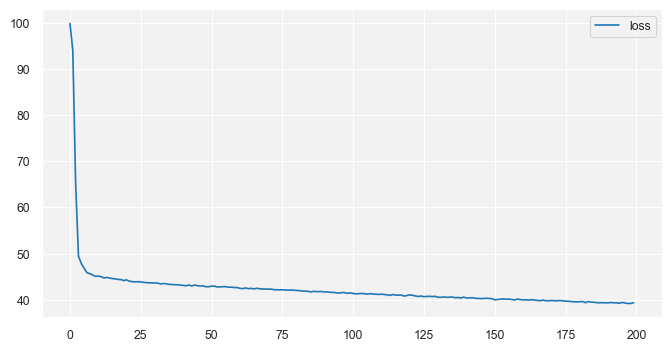

In [218]:
pd.DataFrame(history.history).plot(figsize=(8,4))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

---

In [219]:


model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='elu', input_shape=X.shape[1:]),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(200, activation='elu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(200, activation='elu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1)
])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, use_ema=True)

model.compile(optimizer=adam, loss='mape')

history = model.fit(x=X, y=y, epochs=500, callbacks=[checkpoint_cb, early_stopping], validation_data=(X_test, y_test))

Epoch 1/500


240/240 [==============================] - 1s 2ms/step - loss: 73.5994 - val_loss: 57.6784
Epoch 2/500
240/240 [==============================] - 0s 2ms/step - loss: 52.3207 - val_loss: 52.1843
Epoch 3/500
240/240 [==============================] - 0s 2ms/step - loss: 50.6010 - val_loss: 50.2528
Epoch 4/500
240/240 [==============================] - 0s 2ms/step - loss: 49.1776 - val_loss: 49.2157
Epoch 5/500
240/240 [==============================] - 0s 2ms/step - loss: 48.0963 - val_loss: 48.0799
Epoch 6/500
240/240 [==============================] - 0s 2ms/step - loss: 47.2748 - val_loss: 47.7417
Epoch 7/500
240/240 [==============================] - 0s 2ms/step - loss: 47.2123 - val_loss: 47.7006
Epoch 8/500
240/240 [==============================] - 0s 2ms/step - loss: 46.4465 - val_loss: 47.7323
Epoch 9/500
240/240 [==============================] - 0s 2ms/step - loss: 46.2745 - val_loss: 46.9173
Epoch 10/500
240/240 [==============================] - 0s 2ms/step - loss: 46.4800 -

In [220]:
mse_test = model.evaluate(X_test, y_test)

27/27 [==============================] - 0s 638us/step - loss: 46.4835


In [221]:
predict_train = model.predict(X)
predict_test = model.predict(X_test)

df_train_raw['Predicted'] = predict_train
df_test_raw['Predicted'] = predict_test

 86/240 [=========>....................] - ETA: 0s

27/27 [==============================] - 0s 1ms/step


In [222]:
display(df_train_raw.sample(3))
display(df_test_raw.sample(3))

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Identifier_ordinal,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Location_Type_Tier_3,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Outlet_Type_Supermarket_Type3,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Item_Identifier_0,Item_Identifier_1,Item_Identifier_2,Item_Identifier_3,Item_Identifier_4,Item_Identifier_5,Item_Identifier_6,Item_Identifier_7,Item_Identifier_8,Item_Identifier_9,Item_Identifier_10,Item_Identifier_11,Item_Identifier_12,Item_Identifier_13,Item_Identifier_14,Item_Identifier_15,Item_Identifier_16,Item_Identifier_17,Item_Identifier_18,Item_Identifier_19,Item_Identifier_20,Item_Identifier_21,Item_Identifier_22,Item_Identifier_23,Item_Identifier_24,Item_Identifier_25,Item_Identifier_26,Item_Identifier_27,Item_Identifier_28,Item_Identifier_29,Predicted
4973,12.948031,0,0.303743,196.0110,1985,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,589.2330,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,294.690430
1012,6.890000,1,0.000000,193.4820,1999,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2510.0660,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2381.147461
3821,6.635000,1,0.000000,121.3098,2002,7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2530.7058,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1537.617798


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Identifier_ordinal,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier_1,Outlet_Location_Type_Tier_2,Outlet_Location_Type_Tier_3,Outlet_Type_Grocery_Store,Outlet_Type_Supermarket_Type1,Outlet_Type_Supermarket_Type2,Outlet_Type_Supermarket_Type3,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Item_Identifier_0,Item_Identifier_1,Item_Identifier_2,Item_Identifier_3,Item_Identifier_4,Item_Identifier_5,Item_Identifier_6,Item_Identifier_7,Item_Identifier_8,Item_Identifier_9,Item_Identifier_10,Item_Identifier_11,Item_Identifier_12,Item_Identifier_13,Item_Identifier_14,Item_Identifier_15,Item_Identifier_16,Item_Identifier_17,Item_Identifier_18,Item_Identifier_19,Item_Identifier_20,Item_Identifier_21,Item_Identifier_22,Item_Identifier_23,Item_Identifier_24,Item_Identifier_25,Item_Identifier_26,Item_Identifier_27,Item_Identifier_28,Item_Identifier_29,Predicted
455,18.50,0,0.056816,132.1284,1998,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,263.6568,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,149.356552
234,11.50,0,0.171780,126.0704,2009,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1627.2152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1233.923706
584,18.35,1,0.092150,184.8266,1987,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3872.9586,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2197.510986


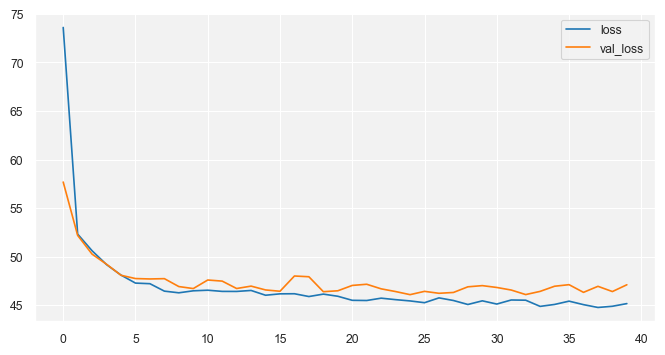

In [223]:
pd.DataFrame(history.history).plot(figsize=(8,4))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [224]:
train_mape = mean_absolute_percentage_error(df_train_raw['Outlet_Sales'], df_train_raw['Predicted'])
test_mape = mean_absolute_percentage_error(df_test_raw['Outlet_Sales'], df_test_raw['Predicted'])
train_mape, test_mape

(0.4283973745900776, 0.46483541154721064)

# Fim